## Homework 3
### Kaley Dodson and Wylie Hampson

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import math

#### Read in the Dominica Outline Data

In [50]:
file_path_dominica = "data/dominica/"
dominica_outline = gpd.read_file(file_path_dominica).set_geometry(col = "geometry").to_crs(epsg = 2002)

# Check Dominica data CRS
dominica_outline.crs

<Projected CRS: EPSG:2002>
Name: Dominica 1945 / British West Indies Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Dominica - onshore.
- bounds: (-61.55, 15.14, -61.2, 15.69)
Coordinate Operation:
- name: British West Indies Grid
- method: Transverse Mercator
Datum: Dominica 1945
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich

#### Plot the Dominica Outline

<AxesSubplot:>

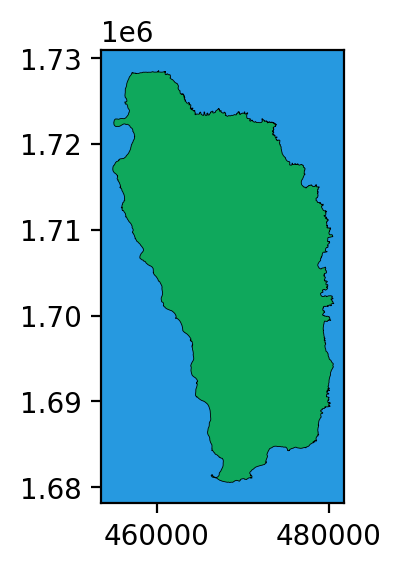

In [51]:
# Make subplots
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.grid(False)
ax.set_facecolor("#2699e0")

# Plot the data
dominica_outline.plot(edgecolor = "black", color = "#0fa85c", facecolor = "none", lw = 0.3, ax = ax)

#### Read in the whale sighting data

In [52]:
file_path_whale = "data/sightings2005_2018.csv"
whale_data = gpd.read_file(file_path_whale)
whale_data

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,None
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,None
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,None
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,None
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,None
...,...,...,...,...,...
4888,4888,2018-05-25 12:01:25,15.39195,-61.572,None
4889,4889,2018-05-25 13:08:29,15.4189,-61.5833,None
4890,4890,2018-05-25 14:50:00,15.443483,-61.60995,None
4891,4891,2018-05-25 15:57:34,15.499866,-61.638333,None


In [53]:
# Bootstrap the geometries to the dataframe
geom = gpd.points_from_xy(whale_data["Long"], whale_data["Lat"], crs = "EPSG:4326")
whale_data = gpd.GeoDataFrame(whale_data, geometry = geom).set_geometry(col = "geometry").to_crs(epsg = 2002)
whale_data

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,POINT (453414.693 1698559.951)
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,POINT (452293.279 1700065.539)
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,POINT (452169.541 1699805.987)
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,POINT (456075.021 1694756.090)
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,POINT (457738.945 1690214.877)
...,...,...,...,...,...
4888,4888,2018-05-25 12:01:25,15.39195,-61.572,POINT (444962.664 1700994.656)
4889,4889,2018-05-25 13:08:29,15.4189,-61.5833,POINT (443744.411 1703972.939)
4890,4890,2018-05-25 14:50:00,15.443483,-61.60995,POINT (440880.303 1706686.453)
4891,4891,2018-05-25 15:57:34,15.499866,-61.638333,POINT (437825.060 1712917.066)


#### Make the grid for our data

In [54]:
# Set the boundaries
xmin, ymin, xmax, ymax = whale_data.total_bounds

# Set the cell size
cell_size = 2000

# Find number of cells in the grid
grid_x_len = xmax - xmin
grid_y_len = ymax - ymin

cells_x = math.ceil(grid_x_len / cell_size)
cells_y = math.ceil(grid_y_len / cell_size)

# Make the coloumns and rows
cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))


#### Make cells at each of the cell points from above.

<AxesSubplot:>

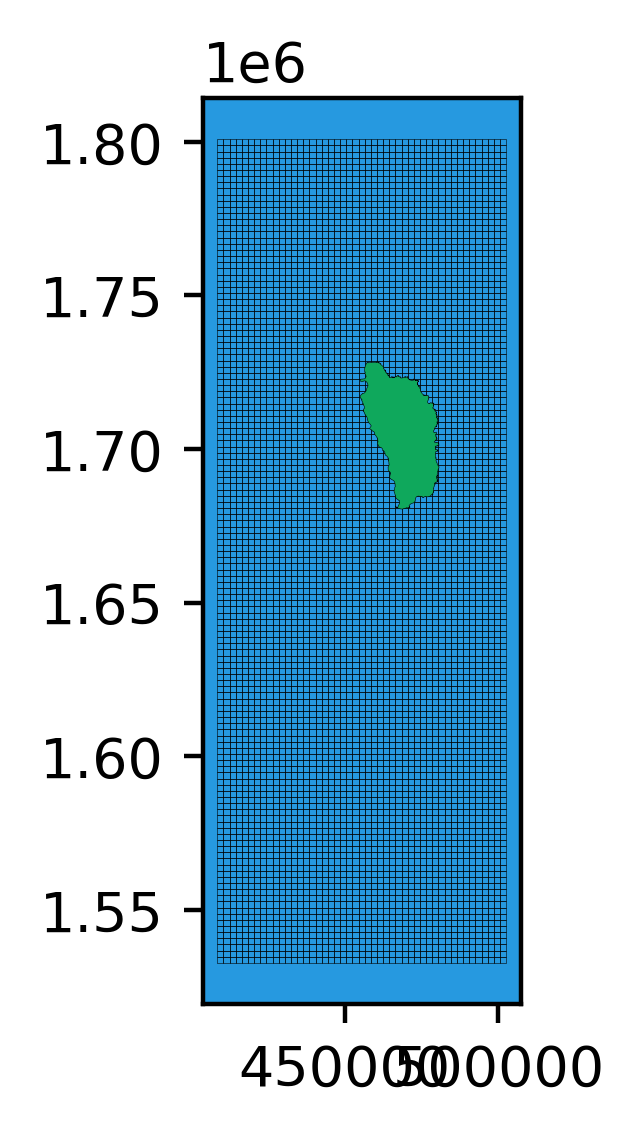

In [66]:
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring)
    return cell

cells = []
for x in cols:
    for y in rows:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)
        
fig, ax_grid = plt.subplots(figsize=(3, 3), dpi=400)
ax_grid.grid(False)
ax_grid.set_facecolor("#2699e0")

grid = gpd.GeoDataFrame({'geometry': cells}, crs=2002)

grid.plot(facecolor = "none", lw = 0.1, ax = ax_grid)
dominica_outline.plot(edgecolor = "black", color = "#0fa85c", facecolor = "none", lw = 0.1, ax = ax_grid)


#### Spatially join the grid geodataframe with the whale sightings dataframe

In [67]:
grid_sightings = gpd.sjoin(grid, whale_data, how = "inner")
grid_sightings

,geometry,index_right,field_1,GPStime,Lat,Long
124,"POLYGON ((408480.652 1780792.746, 410480.652 1...",4327,4327,2018-03-15 06:41:03,16.127,-61.896866
124,"POLYGON ((408480.652 1780792.746, 410480.652 1...",4328,4328,2018-03-15 06:44:05,16.127666,-61.900766
124,"POLYGON ((408480.652 1780792.746, 410480.652 1...",4329,4329,2018-03-15 06:58:17,16.1305,-61.903366
125,"POLYGON ((408480.652 1782792.746, 410480.652 1...",4330,4330,2018-03-15 07:15:33,16.139583,-61.900116
125,"POLYGON ((408480.652 1782792.746, 410480.652 1...",4331,4331,2018-03-15 07:17:30,16.14175,-61.897716
...,...,...,...,...,...,...
5171,"POLYGON ((484480.652 1690792.746, 486480.652 1...",1147,1147,2008-05-04 16:59:36,15.304085,-61.194134
5172,"POLYGON ((484480.652 1692792.746, 486480.652 1...",1148,1148,2008-05-04 17:43:45,15.321439,-61.19188
6030,"POLYGON ((498480.652 1532792.746, 500480.652 1...",609,609,2005-03-20 11:50:05,13.86967067,-61.0794355
6030,"POLYGON ((498480.652 1532792.746, 500480.652 1...",611,611,2005-03-20 12:56:58,13.86967067,-61.0794355


In [68]:
grid['count'] = grid_sightings.groupby(grid_sightings.index).count()["index_right"]
grid


,geometry,count
0,"POLYGON ((408480.652 1532792.746, 410480.652 1...",NaN
1,"POLYGON ((408480.652 1534792.746, 410480.652 1...",NaN
2,"POLYGON ((408480.652 1536792.746, 410480.652 1...",NaN
3,"POLYGON ((408480.652 1538792.746, 410480.652 1...",NaN
4,"POLYGON ((408480.652 1540792.746, 410480.652 1...",NaN
...,...,...
6293,"POLYGON ((500480.652 1790792.746, 502480.652 1...",NaN
6294,"POLYGON ((500480.652 1792792.746, 502480.652 1...",NaN
6295,"POLYGON ((500480.652 1794792.746, 502480.652 1...",NaN
6296,"POLYGON ((500480.652 1796792.746, 502480.652 1...",NaN


POLYGON ((460480.6520836878 1680792.745940924, 456480.6520836878 1682792.745940924, 454480.6520836878 1684792.745940924, 450480.6520836878 1690792.745940924, 446480.6520836878 1708792.745940924, 444480.6520836878 1718792.745940924, 444480.6520836878 1720792.745940924, 448480.6520836878 1720792.745940924, 452480.6520836878 1716792.745940924, 466480.6520836878 1690792.745940924, 466480.6520836878 1688792.745940924, 462480.6520836878 1680792.745940924, 460480.6520836878 1680792.745940924))


<AxesSubplot:>

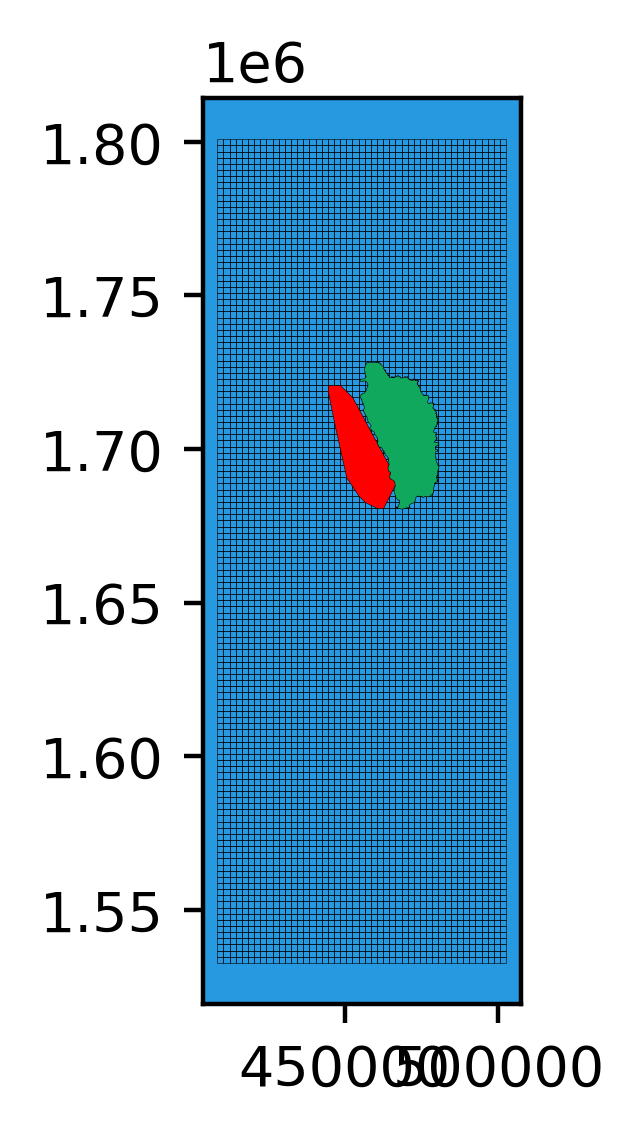

In [78]:
speed_zone = grid[grid['count'] > 20]
speed_zone

speed_zone = speed_zone.unary_union
speed_zone = speed_zone.convex_hull
print(speed_zone)

speed_zone_gdf = gpd.GeoDataFrame()
speed_zone_gdf["geometry"] = None
speed_zone_gdf.at[0, "geometry"] = speed_zone

fig, ax_speed = plt.subplots(figsize=(3, 3), dpi=400)
ax.grid(True)
ax_speed.set_facecolor("#2699e0")

grid.plot(facecolor = "none", lw = 0.1, ax = ax_speed)
speed_zone_gdf.plot(color = "red", edgecolor = "black", lw = 0.1, ax = ax_speed)
dominica_outline.plot(edgecolor = "black", color = "#0fa85c", facecolor = "none", lw = 0.1, ax = ax_speed)